# Data Analytics Group Project

## 1. Data Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython.display import Image

In [2]:
df = pd.read_excel('two-phase flow correlation data.xlsx')

def is_real_and_finite(x):
    if not np.isreal(x):
        return False
    elif not np.isfinite(x):
        return False
    else:
        return True
    
all_data = df[df.columns[1:]].values
numeric_map = df[df.columns[1:]].applymap(is_real_and_finite)
real_rows = numeric_map.all(axis = 1).copy().values
X = np.array(all_data[real_rows, 1:], dtype = 'float')
y = np.array(all_data[real_rows, 0], dtype = 'float')
y = y.reshape(-1, 1)
x_names = [str(x) for x in df.columns[2:]]
y_name = df.columns[1]

print('X matrix dimensions: {}'.format(X.shape))
print('y matrix dimensions: {}'.format(y.shape))
#print(X)
#print(x_names)

X matrix dimensions: (8057, 7)
y matrix dimensions: (8057, 1)


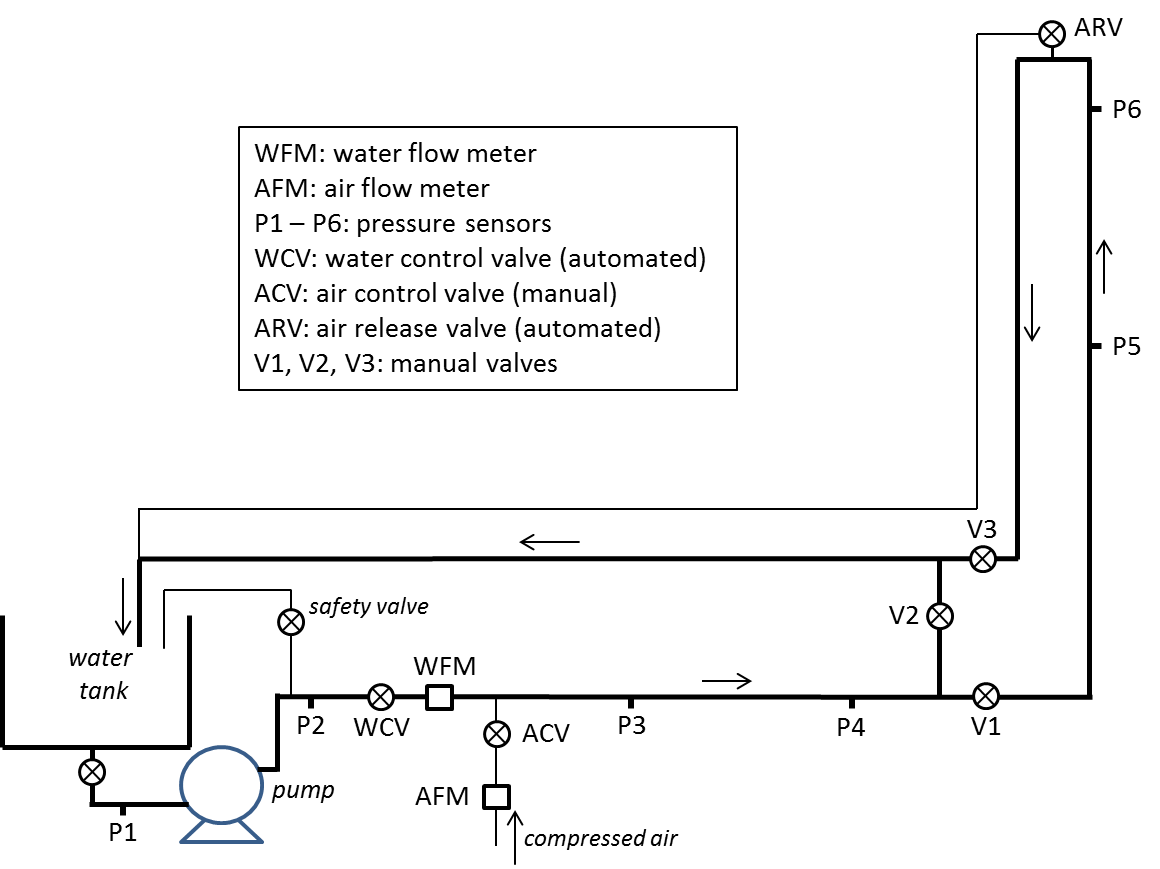

In [3]:
Image(filename='two-phase flow pressure drop.png')

Text(0.5, 0, 'P6 (kPa)')

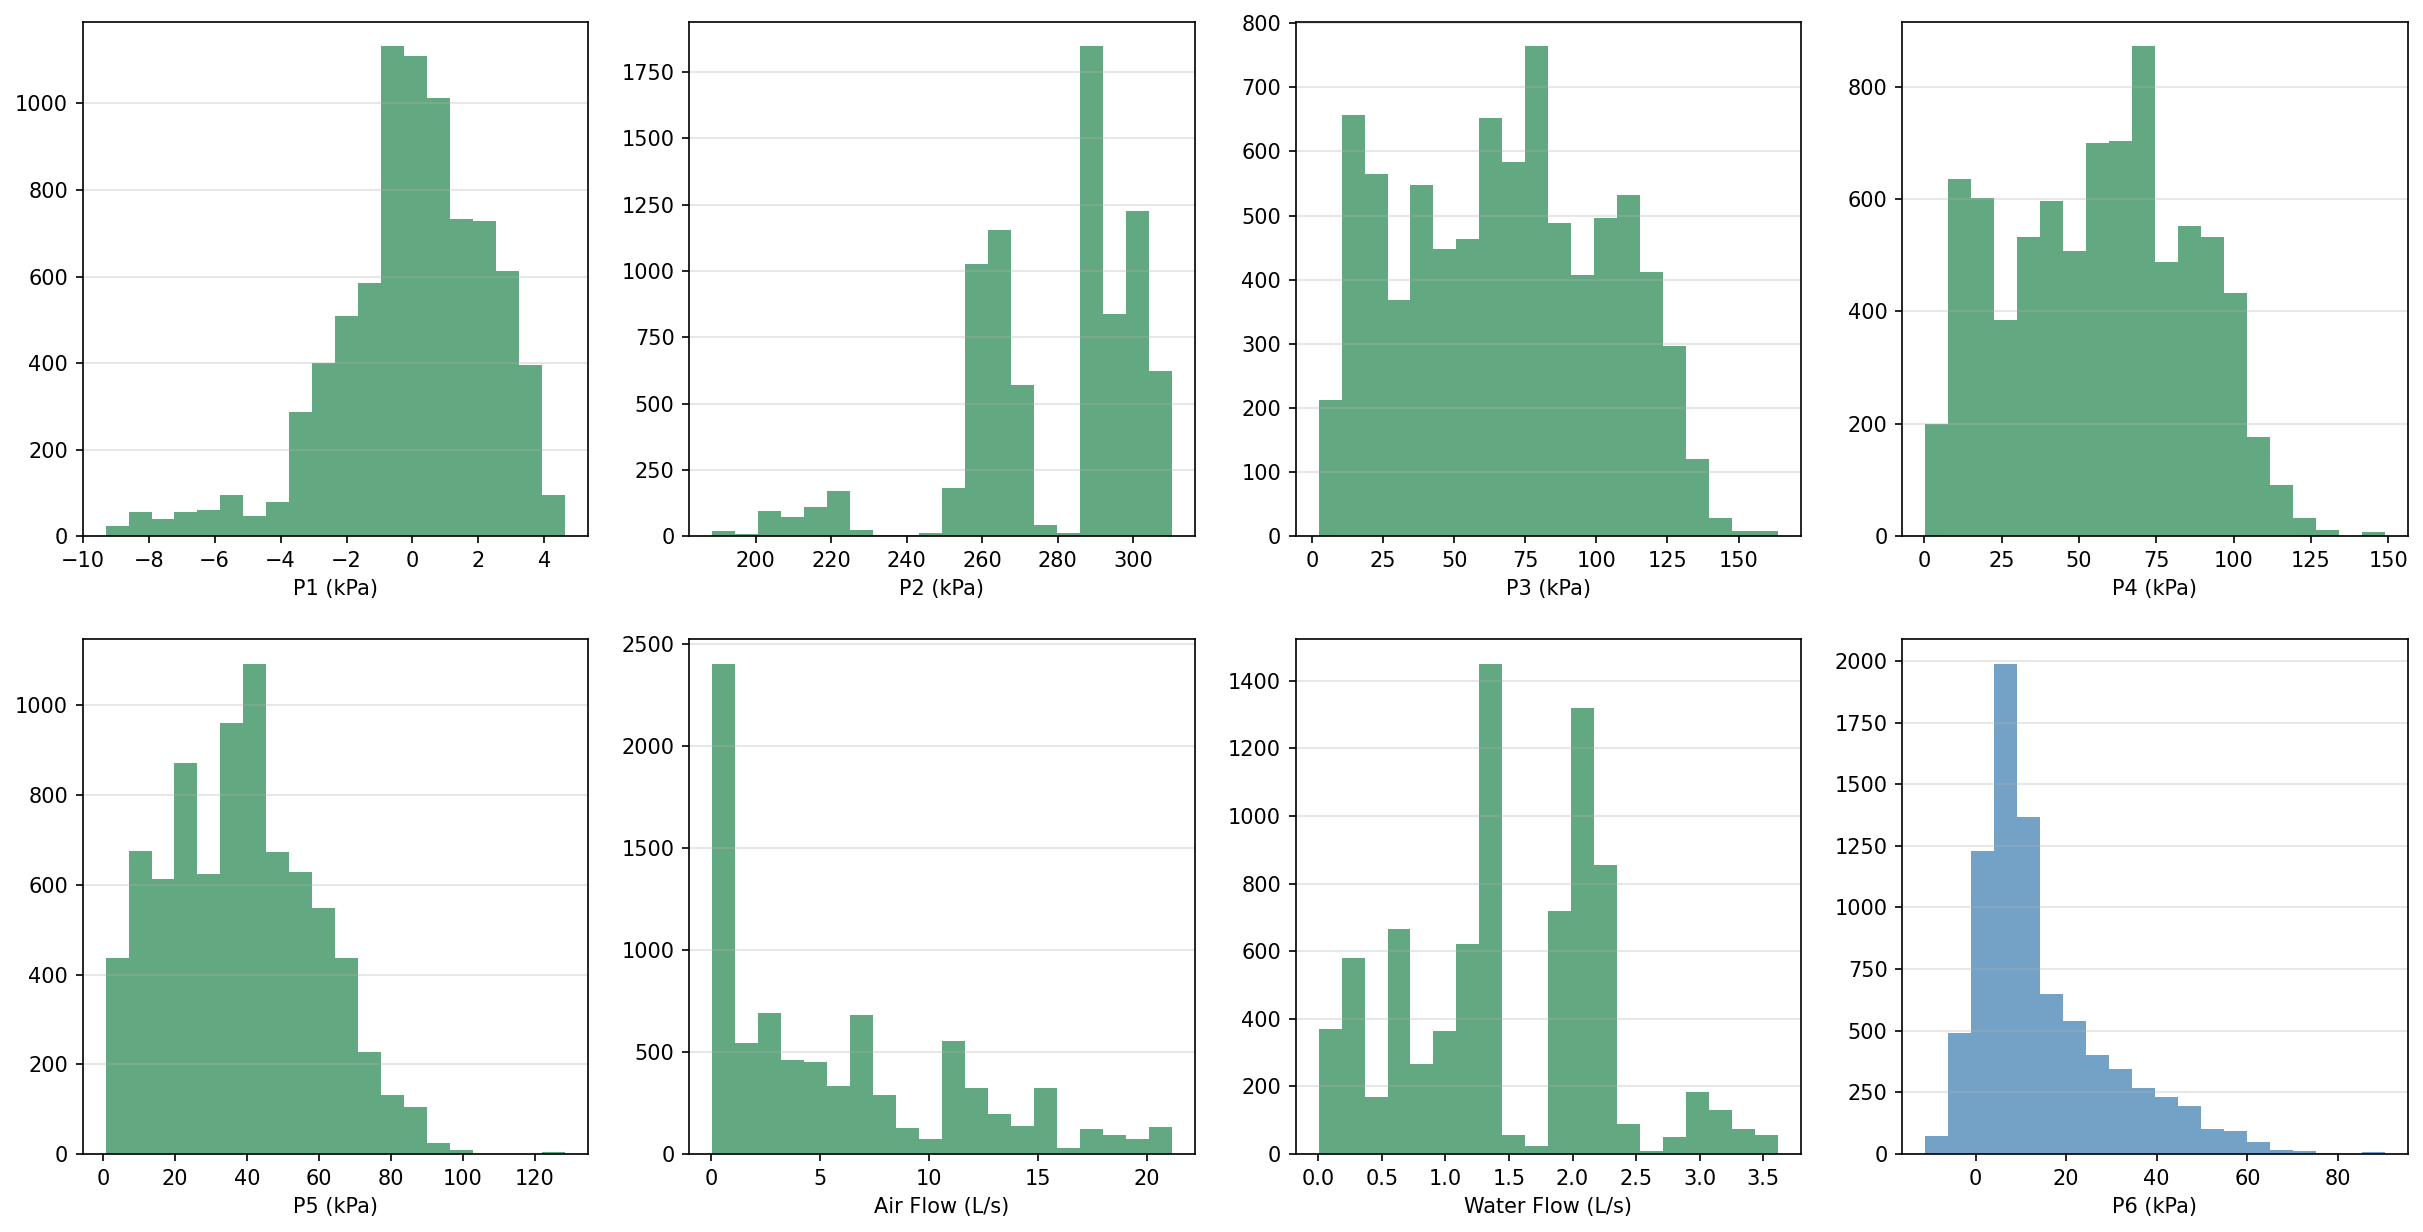

In [4]:
######################################### feature distribution ############################################################

fig, axes = plt.subplots(2, 4, figsize = (20, 10), dpi = 150)
for i in range(2):
    for j in range(4):
        feature = i*4+j
        if feature <= 6:
            axes[i,j].grid(axis='y', linestyle='-', linewidth=1, alpha=0.3)
            axes[i,j].hist(X[:,feature], bins=20, facecolor='seagreen', alpha=0.75)
            axes[i,j].set_xlabel(x_names[feature])
#distribution of target variable
axes[1,-1].grid(axis='y', linestyle='-', linewidth=1, alpha=0.3)
axes[1,-1].hist(y, bins=20, facecolor='steelblue', alpha=0.75)
axes[1,-1].set_xlabel(y_name)

<font color=blue>**Data distributions**</font>

1. "normal": P1, P3, P4
2. "random": P2, Air Flow, Water Flow
3. "damped": P5, P6

[Text(0, 0.5, 'P1'),
 Text(0, 1.5, 'P2'),
 Text(0, 2.5, 'P3'),
 Text(0, 3.5, 'P4'),
 Text(0, 4.5, 'P5'),
 Text(0, 5.5, 'Air'),
 Text(0, 6.5, 'Water')]

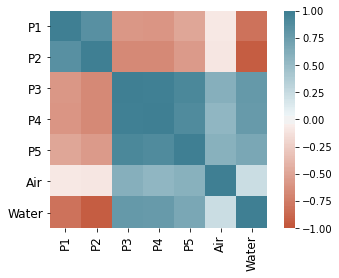

In [5]:
########################################### correlation matrix #############################################################
import pandas as pd
import seaborn as sns

#fig, ax = plt.subplots(figsize = (8, 8))
corr = df[df.columns[2:]].corr()
ticks = ['P1', 'P2', 'P3', 'P4', 'P5', 'Air', 'Water']
ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200), square=True)
ax.set_xticklabels(ticks,fontsize = 12)
ax.set_yticklabels(ticks, fontsize = 12)

<font color=blue>**Discussion**</font>

1. P3 and P4 looks highly correlated
2. P2 and water flow rate are anti-correlated

In [6]:
########################################## Baseline model #################################################################

# feature scaling

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
print(X_scaled.shape)

(8057, 7)


In [7]:
# data spliting

from sklearn.model_selection import train_test_split

# 70%-training, 15%-validation, 15%-test ###generate both validation and test data set in case needing hyperparameter tuning
X_train, X_, y_train, y_ = train_test_split(X_scaled, y, test_size=0.3, shuffle=True)
X_validation, X_test, y_validation, y_test = train_test_split(X_, y_, test_size=0.5, shuffle=True)

print('Train size = {}, Validation size = {}, Test size = {}'.format(y_train.shape, y_validation.shape, y_test.shape))

Train size = (5639, 1), Validation size = (1209, 1), Test size = (1209, 1)


Training r^2 = 0.6053965120863267, Test r^2 = 0.6124701295955136


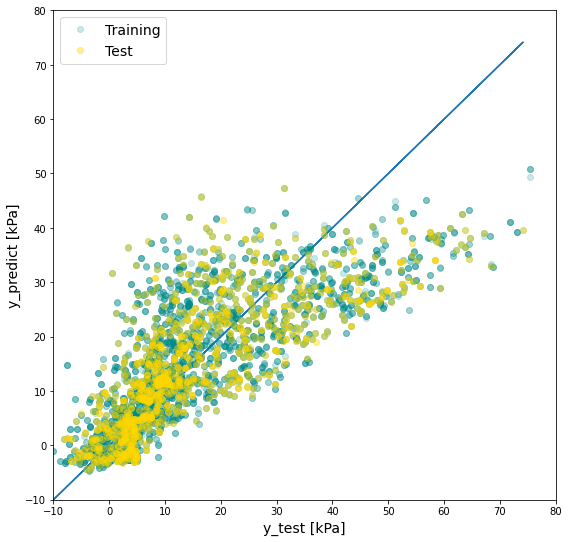

In [8]:
# multi-linear regression

from sklearn.linear_model import LinearRegression

model = LinearRegression() 
model.fit(X_train,y_train)
y_hat_test = model.predict(X_test)
y_hat_train = model.predict(X_train)

r2_train = model.score(X_train,y_train)
r2_test = model.score(X_test,y_test)

print('Training r^2 = {}, Test r^2 = {}'.format(r2_train, r2_test))

fig, ax = plt.subplots(figsize = (9, 9))
ax.plot(y_test, y_test, '-')
ax.plot(y_train, y_hat_train, 'o', label = 'Training', color='darkcyan', alpha = 0.2)
ax.plot(y_test, y_hat_test, 'o', label = 'Test', color='gold', alpha = 0.4)
plt.xlim(-10, 80)
plt.ylim(-10, 80)
ax.set_xlabel('y_test [kPa]', fontsize = 14)
ax.set_ylabel('y_predict [kPa]', fontsize = 14)
plt.legend(loc = 2, fontsize = 14)

<font color=blue>**Discussion**</font>

1. Training data set and test data set have comparable $R^2$
2. Multilinear regression underestimated P6 in the high pressure ragion.
3. Heteroscedasticity error.